# Setup

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
%matplotlib inline

np.random.seed(42)

In [ ]:
!pip install kaggle --upgrade
print ("writing kaggle")
!echo "{\"username\":\"USERNAME\",\"key\":\"KEYYYYYYYYYYY\"}" > kaggle.json
!sudo mkdir -p ~/.kaggle
!sudo cp /content/kaggle.json ~/.kaggle/kaggle.json
print ("got kaggle json copied")
!chmod 600 /root/.kaggle/kaggle.json
!kaggle --version
!kaggle competitions download -c nlp-getting-started

writing kaggle
got kaggle json copied
Kaggle API 1.5.4
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 8.02MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 57.6MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 64.7MB/s]


# EDA from last week

In [ ]:
train_df = pd.read_csv("train.csv")
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
# %%capture
# ! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
# import pandas_profiling as pdpf
# train_df.profile_report()

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


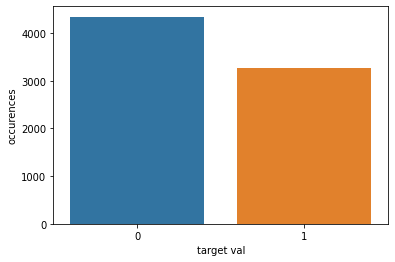

In [ ]:
target_counts = train_df.target.value_counts()
sns.barplot(target_counts.index, target_counts)
plt.gca()
plt.ylabel('occurences')
plt.xlabel('target val')
plt.show()

In [ ]:
def null_counts(df: pd.DataFrame):
    tot = df.isnull().sum().sort_values(ascending=False)
    perc = round(tot/df.shape[0]*100,2)
    return pd.concat([tot,perc],axis=1,keys=['Total','Percentage'])

null_counts(train_df)

,Total,Percentage
location,2533,33.27
keyword,61,0.80
target,0,0.00
text,0,0.00
id,0,0.00


too many null locations

In [ ]:
null_loc_count = train_df.location.isna().sum()
print(f'{null_loc_count} null locations\n')
no_null_loc = train_df.dropna(subset=['location'])
display(no_null_loc)
null_loc_count = no_null_loc.location.isna().sum()
print(f'{null_loc_count} null locations\n')

2533 null locations



,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


0 null locations



better but the locations are still a huge mess

In [ ]:
def unique_values_in_column(data,feature):
    unique_val=pd.Series(data.loc[:,feature].unique())
    return pd.concat([unique_val],axis=1,keys=['Unique Values'])

display(no_null_loc.location.describe())
display(unique_values_in_column(no_null_loc, "location"))

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

,Unique Values
0,Birmingham
1,Est. September 2012 - Bristol
2,AFRICA
3,"Philadelphia, PA"
4,"London, UK"
...,...
3336,TN
3337,#NewcastleuponTyne #UK
3338,"Vancouver, Canada"
3339,London


In [ ]:
import re #regex
top_loc = no_null_loc.location.describe().top
top_loc_freq = no_null_loc.location.describe().freq
print(f'top location: {top_loc}')
print(f'naively, {top_loc} has {top_loc_freq} occurences')
# re.findall(top_loc,no_null_loc[''])
better_top_loc_freq = len(no_null_loc[no_null_loc['location'].str.count(rf'{top_loc}')==1])
print(f'less naively (searching for USA substring), {top_loc} has {better_top_loc_freq} occurences')
print(f'diff of {better_top_loc_freq-top_loc_freq}. wow')

# no_null_loc['location']

top location: USA
naively, USA has 104 occurences
less naively (searching for USA substring), USA has 260 occurences
diff of 156. wow


In [ ]:
num_rows = len(train_df)
num_rows_locations = len(no_null_loc)
locations_null = train_df[train_df["location"].isna()]
num_rows_null_locations = len(locations_null)

num_disaster = len(train_df[train_df['target']==1])
num_no_disaster = num_rows - num_disaster

location_dis = len(no_null_loc[no_null_loc['target'] == 1])
location_no_dis = len(no_null_loc[no_null_loc['target'] != 1])
if location_dis + location_no_dis != num_rows_locations: print("evil is afoot")
null_location_dis = len(locations_null[locations_null['target'] == 1])
null_location_no_dis = len(locations_null[locations_null['target'] != 1])
if null_location_dis + null_location_no_dis != num_rows_null_locations: print("bad stuff happening")

loc_counts = [num_disaster, num_no_disaster, num_rows_locations, num_rows_null_locations, np.NaN, location_dis,location_no_dis,null_location_dis,null_location_no_dis]
loc_percentages = [i/num_rows for i in loc_counts]
loc_disaster_temp = [num_disaster, np.NaN, np.NaN, np.NaN, np.NaN, location_dis, np.NaN, null_location_dis, np.NaN]
loc_disaster_percentages = [i/num_disaster if not None else np.NaN for i in loc_disaster_temp]
loc_no_disaster_temp = [np.NaN, num_no_disaster, np.NaN, np.NaN, np.NaN, np.NaN,location_no_dis,np.NaN,null_location_no_dis]
loc_no_disaster_percentages = [i/num_no_disaster if not None else np.NaN for i in loc_no_disaster_temp]

loc_analyze_df = pd.DataFrame(
    np.array([loc_counts, loc_percentages, loc_disaster_percentages, loc_no_disaster_percentages]).T
    , columns=['count','% of all tweets', '% of disasters', '% no disaster'], index=['Disaster','No Disaster','Location', 'No Location','Spacer','Location and Disaster','Location no Disaster', 'No Location and Disaster', 'No Location no Disaster']
    )


loc_analyze_df

,count,% of all tweets,% of disasters,% no disaster
Disaster,3271.0,0.429660,1.000000,NaN
No Disaster,4342.0,0.570340,NaN,1.00000
Location,5080.0,0.667280,NaN,NaN
No Location,2533.0,0.332720,NaN,NaN
Spacer,NaN,NaN,NaN,NaN
Location and Disaster,2196.0,0.288454,0.671354,NaN
Location no Disaster,2884.0,0.378826,NaN,0.66421
No Location and Disaster,1075.0,0.141206,0.328646,NaN
No Location no Disaster,1458.0,0.191515,NaN,0.33579


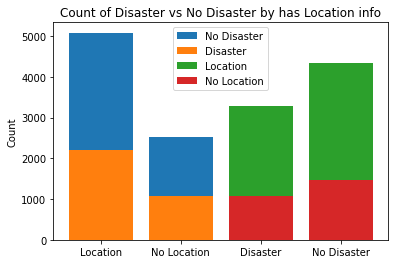

In [ ]:
loc_dis_df = loc_analyze_df.loc[['Location and Disaster','Location no Disaster', 'No Location and Disaster', 'No Location no Disaster']]
fig, ax = plt.subplots()
ax.bar(x=['Location','No Location'],height=loc_dis_df['count'].values[1::2],label='No Disaster',bottom=loc_dis_df['count'].values[0::2])
ax.bar(x=['Location','No Location'],height=loc_dis_df['count'].values[0::2],label='Disaster')
ax.bar(x=['Disaster','No Disaster'],height=loc_dis_df['count'].values[0:2],label='Location',bottom=loc_dis_df['count'].values[2:])
ax.bar(x=['Disaster','No Disaster'],height=loc_dis_df['count'].values[2:],label='No Location')
ax.set_ylabel('Count')
ax.set_title('Count of Disaster vs No Disaster by has Location info')
ax.legend()
plt.show()

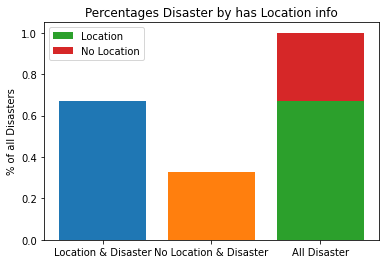

In [ ]:
loc_dis_df = loc_analyze_df.loc[['Location and Disaster','Location no Disaster', 'No Location and Disaster', 'No Location no Disaster']]
fig, ax = plt.subplots()
ax.bar(x=['Location & Disaster'],height=loc_dis_df['% of disasters'].values[0])
ax.bar(x=['No Location & Disaster'],height=loc_dis_df['% of disasters'].values[2])
ax.bar(x=['All Disaster'],height=loc_dis_df['% of disasters'].values[0],label='Location')
ax.bar(x=['All Disaster'],height=loc_dis_df['% of disasters'].values[2],bottom=loc_dis_df['% of disasters'].values[0],label='No Location')
# ax.bar(x=['Location','No Location'],height=loc_dis_df['count'].values[0::2],label='Disaster')
# ax.bar(x=['Disaster','No Disaster'],height=loc_dis_df['count'].values[0:2],label='Location',bottom=loc_dis_df['count'].values[2:])
# ax.bar(x=['Disaster','No Disaster'],height=loc_dis_df['count'].values[2:],label='No Location')
ax.set_ylabel('% of all Disasters')
ax.set_title('Percentages Disaster by has Location info')
ax.legend()
plt.show()

In [ ]:
no_null_loc

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


In [ ]:
null_key_count = train_df['keyword'].isna().sum()
print(f'{null_key_count} null keywords\n')
no_null_key = train_df.dropna(subset=['keyword'])
display(no_null_key)
null_key_count = no_null_key['keyword'].isna().sum()
print(f'{null_key_count} null keys\n')

61 null keywords



,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


0 null keys



In [ ]:
def unique_values_in_column(data,feature):
    unique_val=pd.Series(data.loc[:,feature].unique())
    return pd.concat([unique_val],axis=1,keys=['Unique Values'])

display(no_null_key.keyword.describe())
display(unique_values_in_column(no_null_key, "keyword"))

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

,Unique Values
0,ablaze
1,accident
2,aftershock
3,airplane%20accident
4,ambulance
...,...
216,wounded
217,wounds
218,wreck
219,wreckage


In [ ]:
no_null_key[no_null_key['keyword'].str.count('%')==1]

,id,keyword,location,text,target
136,196,airplane%20accident,"19.600858, -99.047821",Experts in France begin examining airplane deb...,1
137,197,airplane%20accident,Pennsylvania,Strict liability in the context of an airplane...,1
138,198,airplane%20accident,"Salt Lake City, Utah",@crobscarla your lifetime odds of dying from a...,0
139,199,airplane%20accident,"Palo Alto, CA",Experts in France begin examining airplane deb...,1
140,201,airplane%20accident,NaN,@AlexAllTimeLow awwww they're on an airplane a...,1
...,...,...,...,...,...
7320,10479,wild%20fires,NaN,@EnzasBargains A5 Donated some fruit snacks &a...,1
7321,10481,wild%20fires,NaN,Wild land fires.. Here I come. ??????,1
7322,10482,wild%20fires,Canada,@WBCShirl2 Yes God doessnt change he says not...,0
7323,10483,wild%20fires,NaN,My heart goes out to all those effected by the...,1


In [ ]:
import urllib.parse

num_perc_in_keyword = len(no_null_key[no_null_key['keyword'].str.count('%')==1])
print(f'{num_perc_in_keyword} occurences of % in keyword column\n\n')
no_null_key['decKey'] = [urllib.parse.unquote(i) for i in no_null_key['keyword']]

display(no_null_key)
print("\n")
num_perc_in_deckey = len(no_null_key[no_null_key['decKey'].str.count('%')==1])
print(f'{num_perc_in_deckey} occurences of % in decKey column')

1132 occurences of % in keyword column




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,keyword,location,text,target,decKey
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,ablaze
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,ablaze
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,ablaze
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,ablaze
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,ablaze
...,...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0,wrecked
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,wrecked
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,wrecked
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,wrecked




0 occurences of % in decKey column


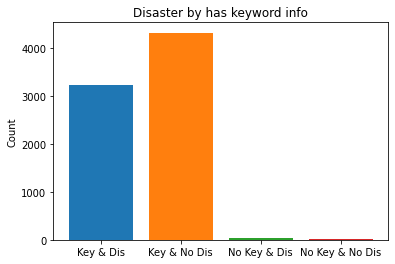

In [ ]:
key_dis = len(no_null_key[no_null_key['target']==1])
key_no_dis = len(no_null_key) - len(no_null_key[no_null_key['target']==1])

keys_null = train_df[train_df["keyword"].isna()]
num_keys_null = len(keys_null)

no_key_dis = len(keys_null[keys_null['target']==1])
no_key_no_dis = len(keys_null[keys_null['target']==0])

keys_counts = [key_dis,key_no_dis,no_key_dis,no_key_no_dis]

fig, ax = plt.subplots()
ax.bar(x=['Key & Dis'],height=keys_counts[0])
ax.bar(x=['Key & No Dis'],height=keys_counts[1])
ax.bar(x=['No Key & Dis'],height=keys_counts[2])
ax.bar(x=['No Key & No Dis'],height=keys_counts[3])
# ax.bar(x=['All Disaster'],height=loc_dis_df['% of disasters'].values[0],label='Location')
# ax.bar(x=['All Disaster'],height=loc_dis_df['% of disasters'].values[2],bottom=loc_dis_df['% of disasters'].values[0],label='No Location')
# ax.bar(x=['Location','No Location'],height=loc_dis_df['count'].values[0::2],label='Disaster')
# ax.bar(x=['Disaster','No Disaster'],height=loc_dis_df['count'].values[0:2],label='Location',bottom=loc_dis_df['count'].values[2:])
# ax.bar(x=['Disaster','No Disaster'],height=loc_dis_df['count'].values[2:],label='No Location')
ax.set_ylabel('Count')
ax.set_title('Disaster by has keyword info')
# ax.legend()
plt.show()

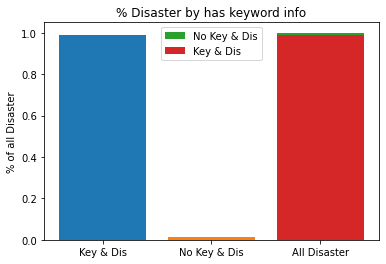

In [ ]:
fig, ax = plt.subplots()
ax.bar(x=['Key & Dis'],height=keys_counts[0]/num_disaster)
ax.bar(x=['No Key & Dis'],height=keys_counts[2]/num_disaster)
ax.bar(x=['All Disaster'],height=keys_counts[2]/num_disaster,bottom=keys_counts[0]/num_disaster,label='No Key & Dis')
ax.bar(x=['All Disaster'],height=keys_counts[0]/num_disaster,label='Key & Dis')
# ax.bar(x=['All Disaster'],height=loc_dis_df['% of disasters'].values[0],label='Location')
# ax.bar(x=['All Disaster'],height=loc_dis_df['% of disasters'].values[2],bottom=loc_dis_df['% of disasters'].values[0],label='No Location')
# ax.bar(x=['Location','No Location'],height=loc_dis_df['count'].values[0::2],label='Disaster')
# ax.bar(x=['Disaster','No Disaster'],height=loc_dis_df['count'].values[0:2],label='Location',bottom=loc_dis_df['count'].values[2:])
# ax.bar(x=['Disaster','No Disaster'],height=loc_dis_df['count'].values[2:],label='No Location')
ax.set_ylabel('% of all Disaster')
ax.set_title('% Disaster by has keyword info')
ax.legend(loc=9)
plt.show()

In [ ]:
no_null_key_grouped = no_null_key[['decKey','target','id']].groupby(by=['decKey','target'],sort=True,as_index=False).count()
display(no_null_key_grouped)
no_null_key_grouped['count'] = no_null_key_grouped['id']
no_null_key_grouped = no_null_key_grouped.drop('id',axis=1)
no_null_key_grouped.columns
# no_null_key_grouped['keys'] = no_null_key_grouped['decKey']
# no_null_key_grouped['dis'] = no_null_key_grouped['target']
# no_null_key_grouped = no_null_key_grouped.sort_values(by='count',ascending=False)
# display(no_null_key_grouped)

,decKey,target,id
0,ablaze,0,23
1,ablaze,1,13
2,accident,0,11
3,accident,1,24
4,aftershock,0,34
...,...,...,...
433,wreck,0,30
434,wreck,1,7
435,wreckage,1,39
436,wrecked,0,36


Index(['decKey', 'target', 'count'], dtype='object')

In [ ]:
# no_null_key_grouped = no_null_key[['decKey','target','id']].groupby(by=['decKey','target'],sort=True,as_index=False).count()
# display(no_null_key_grouped)
# no_null_key_grouped['count'] = no_null_key_grouped['id']
# no_null_key_grouped = no_null_key_grouped.drop('id',axis=1)
# no_null_key_grouped = no_null_key_grouped.sort_values(by='count',ascending=False)
# display(no_null_key_grouped)

In [ ]:
# no_null_key_grouped[no_null_key_grouped['decKey']=='body bags']

In [ ]:
# no_null_key_dis = no_null_key_grouped[no_null_key_grouped['target']==1]
# no_null_key_no_dis = no_null_key_grouped[no_null_key_grouped['target']==0]

In [ ]:
# top_key_dis = pd.concat([no_null_key_dis.head(10),no_null_key_dis.tail(10)])
# top_key_no_dis = pd.concat([no_null_key_no_dis.head(10),no_null_key_no_dis.tail(10)])

In [ ]:
# fig, ax = plt.subplots(figsize=(25,10))
# ax.bar(x=top_key_dis['decKey'],height=top_key_dis['count'])
# # ax.bar(x=top_key_no_dis['decKey'],height=top_key_no_dis['count'])
# ax.set_ylabel('Count')
# ax.set_title('Disaster by Location Count')
# # ax.legend()
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(30,10))
# # ax.bar(x=top_key_dis['decKey'],height=top_key_dis['count'])
# ax.bar(x=top_key_no_dis['decKey'],height=top_key_no_dis['count'],color='blue')
# ax.set_ylabel('Count')
# ax.set_title('No Disaster by Location Count')
# # ax.legend()
# plt.show()

# Model

In [ ]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
#just going to use the text and target
train_df_old = train_df.copy()
del train_df
train_df = train_df_old[['text','target']]
train_df

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [ ]:
train_df.loc[0].text

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [ ]:
train, test = train_test_split(train_df, test_size=0.15, random_state=42)

In [ ]:
X_train = train['text']
X_test = test['text']
y_train = train['target']
y_test = test['target']

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
mod = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(mod, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(X_train[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.38306904, -0.26895744, -0.1783666 , -0.05940446, -0.1418173 ,
        -0.02581871, -0.16207267, -0.02527309,  0.13453504, -0.10728086,
        -0.28815022,  0.17120948,  0.42583925,  0.03508604,  0.13450435,
         0.14326034,  0.07433679, -0.26144627,  0.04642232, -0.00980929,
         0.06049365, -0.03286843,  0.07263126,  0.11214203, -0.36324373,
         0.21613836, -0.04129212,  0.07044894, -0.45675507, -0.10476655,
        -0.09517228, -0.02559366,  0.02278632, -0.05655023,  0.06491455,
        -0.2687193 , -0.10636877,  0.07197054, -0.02314625,  0.11502782,
        -0.4052743 , -0.02582416, -0.1307396 , -0.12363352, -0.1977048 ,
         0.04596464,  0.19815515,  0.28096366,  0.02721545, -0.07089735],
       [ 0.15176238, -0.46694568,  0.33788937,  0.0048677 , -0.28616798,
        -0.09412175, -0.04541719,  0.06752358, -0.077677  ,  0.21818641,
        -0.03859768,  0.40443882, -0.0900542 , -0.04961128,  0.05647644,
 

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dropout(0.85))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(from_logits=True), 
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [ ]:
n_train = len(X_train)
n_86perc = int(n_train//1.17)
X_train_part = X_train[:n_86perc]
X_val = X_train[n_86perc:]
y_train_part = y_train[:n_86perc]
y_val = y_train[n_86perc:]
print(f"full length:{len(X_train)}\npartial training length: {len(X_train_part)}\nvalidation length: {len(X_val)}")

full length:6471
partial training length: 5530
validation length: 941


In [ ]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

In [ ]:
history = model.fit( X_train_part, y_train_part,
                    epochs=40, batch_size=512,
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/40
11/11 [==============================] - 3s 84ms/step - loss: 0.7394 - accuracy: 0.5492 - val_loss: 0.6631 - val_accuracy: 0.6249
Epoch 2/40
11/11 [==============================] - 1s 61ms/step - loss: 0.7116 - accuracy: 0.5631 - val_loss: 0.6543 - val_accuracy: 0.6684
Epoch 3/40
11/11 [==============================] - 1s 61ms/step - loss: 0.7020 - accuracy: 0.5676 - val_loss: 0.6472 - val_accuracy: 0.6897
Epoch 4/40
11/11 [==============================] - 1s 61ms/step - loss: 0.6837 - accuracy: 0.5826 - val_loss: 0.6413 - val_accuracy: 0.7024
Epoch 5/40
11/11 [==============================] - 1s 62ms/step - loss: 0.6780 - accuracy: 0.5850 - val_loss: 0.6362 - val_accuracy: 0.7216
Epoch 6/40
11/11 [==============================] - 1s 63ms/step - loss: 0.6670 - accuracy: 0.5928 - val_loss: 0.6315 - val_accuracy: 0.7269
Epoch 7/40
11/11 [==============================] - 1s 63ms/step - loss: 0.6551 - accuracy: 0.6118 - val_loss: 0.6263 - val_accuracy: 0.7322
Epoch 8/40
11

In [ ]:
results = model.evaluate(X_test, y_test)
print(f"\nTest set evaluation results:")
for i,x in enumerate(results):
    print(f"{model.metrics_names[i]} : {x : 0.4f}")

# print(f"{results}")

36/36 [==============================] - 0s 7ms/step - loss: 0.4785 - accuracy: 0.7811

Test set evaluation results:
loss :  0.4785
accuracy :  0.7811


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

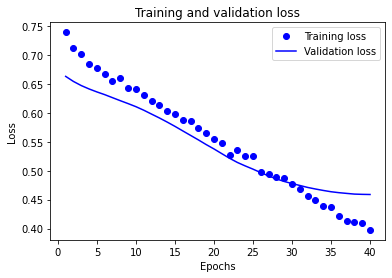

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

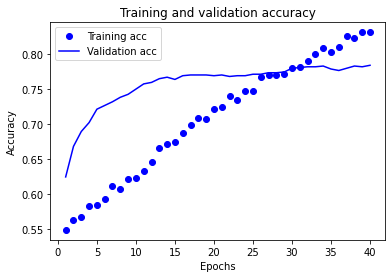

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
X_test

2644    So you have a new weapon that can cause un-ima...
2227    The f$&amp;@ing things I do for #GISHWHES Just...
5448    DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...
132     Aftershock back to school kick off was great. ...
6845    in response to trauma Children of Addicts deve...
                              ...                        
1393    ??\nWarfighting Robots Could Reduce Civilian C...
1335    @fewmoretweets all lives matter. Just not a fa...
5717    WomanÛªs GPS app guides rescuers to injured b...
4921    Tonight It's Going To Be Mayhem @ #4PlayThursd...
198       Why is there an ambulance right outside my work
Name: text, Length: 1142, dtype: object

In [ ]:
from sklearn.metrics import f1_score

preds_test = model.predict(X_test)
print(f"f1 score: {f1_score(y_test, preds_test > 0)}")

f1 score: 0.736842105263158


In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
model.save('model',save_format=)

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [ ]:
tf.saved_model.save(model, 'm')

INFO:tensorflow:Assets written to: m/assets


INFO:tensorflow:Assets written to: m/assets
